In [1]:
from helper_functions import *
from IPython.display import Image

## Aim

To implement the algorithm found in this paper : https://arxiv.org/abs/2012.13453

## Overview

Overview of the paper : Use of evolutionary algorithm to minimize the cost function so as to estimate the ground state for a model. The evolutionary algorithm part involves inserting/deleting/modifying quantum gates at random locations in the quantum circuit.

In practice, Variational Quantum Eigensolvers (VQEs) suffer from the large quantum computational overhead in estimating cost function gradients for large parameter sets. Here, we consider weight-agnostic learning and investigate the use of evolutionary algorithms which first spawn circuit’s offspring and then evaluate them via genetic competition, thus circumventing some of the previous issues common to parameter-based approaches. We use our methods to solve the transverse field Ising Hamiltonian and the Sherrington-Kirkpatrick spin model.


Following figure shows the outline of evolutionary circuit discovery: Starting with a random initial parent with known loss value, we create copies and mutate them using our custom mutation strategy using operations as shown on the right side of the image. The offspring population is then evaluated on the quantum machine. The circuit with lowest loss value (the original parent included) becomes the parent circuit of the next generation. This procedure is repeated until an appropriate convergence criterion is satisfied. 

![](images/5.PNG)

The mutation performs one of 4 actions with certain probabilities, we show these on the right side of above image. <br>
INSERT: Add random gate at random position; <br>
DELETE: Delete gate at random position; <br>
SWAP: Replace gate at random position with random new gate; <br>
MODIFY: Change parameter of gate at random position.<br>




![](images/6.PNG)

The above figure shows circuit diagram of the gradual evolution of the circuit architecture for the transverse field Ising Hamiltonian, (Left) after 10 generations and (Right) after 150 generations. <br>
The notation Ri represents a rotation gate wrt axis i (for the purpose of clarity the explicit rotation’s angles are omitted). Note that gates spanning multiple qubits are only applied to the upper- and lowermost qubit. Note that by generation 150 some previously present gates with redundant parameters are removed. Moreover, the circuit generally reflects intelligence in its design and indeed is nicely aligned with the expected useful set of gates for the TFI problem.


To implement the evolution, at each generation, we maintain a variable called "current_circuit" which contains the current state of circuit in special format. <br>
The format is: <br>
   

current_circuit = \[ [gates_of_qubit0], [gates_of_qubit1], [gates_of_qubit2], [gates_of_qubit3], ...., [gates_of_qubit8], [gates_of_qubit9] \] <br>
where "gates_of_qubitn" is a list of gates (in correct order) that are applied to qubit n <br>
Ex:
        If <br>
        0th qubit has Ry, <br>
        1st qubit has Rx and then  Ry, <br>
        2nd qubit has Rxx, <br>
        3rd qubit has Ryy and then  Rzz and then Rx, <br>
        4th qubit has Rxx and then  Ry, <br>
        5th qubit has Rzz, <br>
        6th qubit has no gate, <br>
        7th qubit has Rx and then  Rz, <br>
        8th qubit has Ryy, <br>
        9th qubit has Ry, <br>
        
Then,


In [3]:
current_circuit = [[['Ry', 1.2]], 
 [['Rx', 6.1], ['Ry', 3.9]], 
 [['Rxx', 3.3, 4, 0]], 
 [['Ryy', 6.1, 8, 0], ['Rzz', 4.1, 5, 0], ['Rx', 5.7]], 
 [['Rxx', 3.3, 2, 0], ['Ry', 1.5]],
 [['Rzz', 4.1, 3, 1]], 
 [],
 [['Rx', 0.9], ['Rz', 4.4]],
 [['Ryy', 6.1, 3, 0]],
 [['Ry', 4.2]]]

Each gate is defined as: <br>  <br>
If single gate, \[ "Gate type" , "Gate Argument" \] <br> For ex: \['Ry', 4.2\] <br> <br>
If double gate, \[ "Gate type" , "Gate Argument", "Qubit no. of the other qubit" , "Index where this gate is applied to other qubit" \] <br> For ex: \['Rzz', 4.1, 3, 1\] <br>

Now let's try to use these 4 functions - Insert, Delete, Swap, Modify

We start with an empty circuit

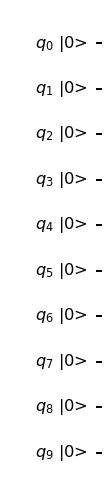

In [4]:
current_circuit=[[] for i in range(10)]
qiskit_circuit=get_circuit(current_circuit)
qiskit_circuit.draw(initial_state=True, output="mpl")

We now apply insert function to this circuit

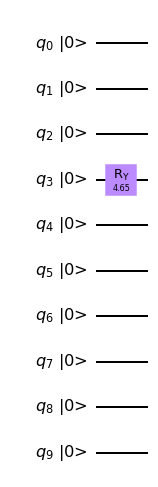

In [5]:
current_circuit=insert(current_circuit)
qiskit_circuit=get_circuit(current_circuit)
qiskit_circuit.draw(initial_state=True, output="mpl")

Let's now apply insert function multiple times to add more gates

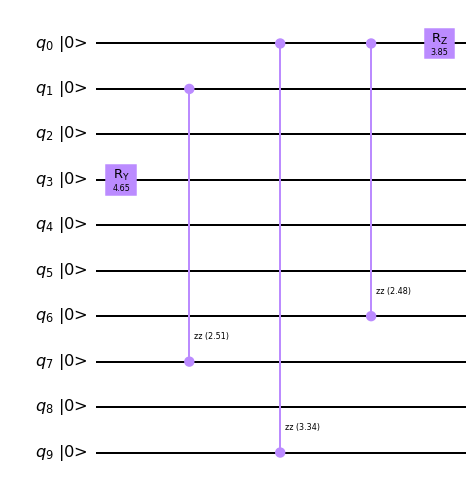

In [6]:
current_circuit=insert(current_circuit)
current_circuit=insert(current_circuit)
current_circuit=insert(current_circuit)
current_circuit=insert(current_circuit)
qiskit_circuit=get_circuit(current_circuit)
qiskit_circuit.draw(initial_state=True, output="mpl")

We now apply delete function to this circuit

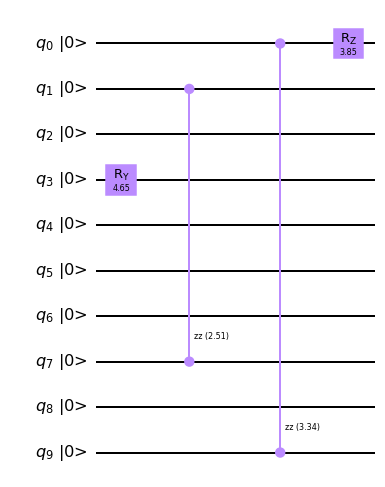

In [7]:
current_circuit=delete(current_circuit)
qiskit_circuit=get_circuit(current_circuit)
qiskit_circuit.draw(initial_state=True, output="mpl")

We see that the Rz gate (on qubit 4) gets removed by the delete operation

We now apply swap function to this circuit

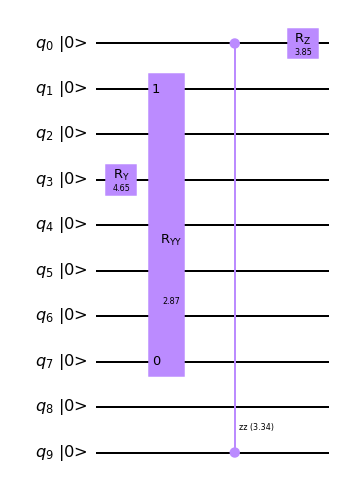

In [8]:
current_circuit=swap(current_circuit)
qiskit_circuit=get_circuit(current_circuit)
qiskit_circuit.draw(initial_state=True, output="mpl")

We see that the Rzz gate (between qubits 2 and 3) gets swapped by the Rxx gate

We now apply mopdify function to this circuit

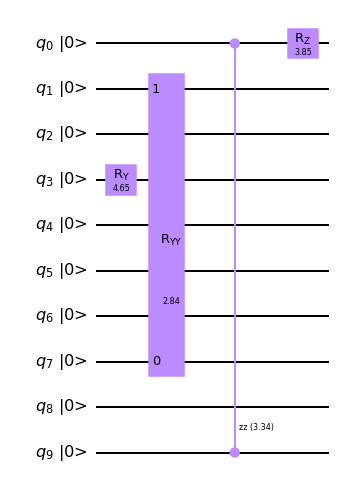

In [9]:
current_circuit=modify(current_circuit)
qiskit_circuit=get_circuit(current_circuit)
qiskit_circuit.draw(initial_state=True, output="mpl")

We see that the Ry gate (on qubit 9) gets its parameter changed from 2.33 to 2.15

Evolutionary algorithms (EA) iteratively work with a population of solution candidates, and optimization is carried out over a number of generations. In each generation, μ candidates that constitute the parent population produce an offspring population of λ candidates by means of crossover and mutation; these operations are specific to the problem domain at hand.

In our application, candidates are quantum circuits, and mutations cause small changes to the
circuit, such as addition or removal of a gate, or nudging of a gate’s parameter. The newly obtained
offspring candidates are evaluated with respect to the loss function and sorted into the
parent population, replacing parents with higher loss value. This selection step emulates natural
selection in biology, where better adapted individuals survive. 


As the parent population is maintained during selection, the best individual that was ever observed since the first generation always survives. This property is known as elitism and ensures that the overall best loss value always monotonically decreases over time. The μ best candidates proceed to form the parent population of the next generation. If none of the offspring individuals yields an improvement, the original parent population carries over to the next generation unchanged. This EA scheme is known in literature as a (μ + λ) EA and is among the most representative and best-understood evolutionary optimization strategies.

Using an evolutionary algorithm we attempt to find a circuit \\( U_c \: \epsilon \: \mu \\) , which performs best with respect to some cost function f. <br>
Every circuit \\( U_c \\) is a product of unitary matrices such that \\( U_c \: = \Sigma _i \: U_i \\) , each of which is defined by generator and a parameter pair ( \\( g_i , \theta _i \\) ) , i.e.

![](images/7.PNG)

In this notation \\( g_i \\) denotes an element of a set of Pauli-generators G for experiments chosen to be

![](images/8.PNG)

with \\( \mu \: \epsilon \: \{x,y,z\} \\) and  \\(i \neq j \\) and \\( 1 \: \leq i,j  \: \leq n \\)

For each circuit there is an associated value defined by the expectation with respect to some target Hamiltonian H, <br> written in density matrix formulation with | \\( \psi _0  \\) > as initial state:


![](images/9.PNG)

Finding a circuit \\( U_opt \\) which minimizes \\( f \\) is an optimization task over the search space \\( \mu \\). This
space \\( \mu \\) is defined through a mix of discrete and continous values, namely generators \\( g_i \\) and qubit
indices and parameters \\( \theta _i \\), respectively. While traditional gradient methods can optimize only the
real-valued parameters \\( \theta _i \\) on fixed circuit layouts, they cannot learn the overall circuit structure,
because the existence or non-existence of a gate, for instance, is not differentiable.


We use the publicly available quantum computing library qiskit to define and modify quantum
circuits in Python. This library is also capable of simulating quantum computing, both by
calculating amplitudes analytically and by simulating shots. <br> <br>
We use a custom EA implementation to perform a (1+4)-EA using a special multi-level mutation
strategy, which we explain in the following paragraph. The optimization run starts with a minimal
random circuit, consisting of only a single gate with a uniformly sampled parameter. From this
initial parent circuit we make 4 copies and mutate them independently using our mutation strategy,
which yields the offspring population. From the measurement results we derive a loss value, which we explain in detail
in another paragraph further down this section. The entire population is then sorted by loss
value, and the circuit with lowest loss becomes the new parent circuit for the next generation.
This process is repeated for 150 generations, during which the parent’s loss value monotonically
decreases, approaching the global optimum.


Mutation strategy: <br> <br>
The mutation strategy consists of a two-level random process. In a first
step, we choose an action from a list of options. Then, we sample parameters for the chosen
action and apply the changes directly to the circuit object. Possible actions (with their respective
occurrence probabilities in parentheses) are: <br> <br>
• INSERT (50%): Sample generator g and parameter theta uniformly and insert the corresponding
gate at a random position. <br>
• DELETE (10%): Delete gate at a random position from the circuit. <br>
• SWAP (10%): Combination of Delete and Insert at the same randomly chosen position <br>
• MODIFY (30%): Modify parameter of randomly chosen gate according to theta = theta+ \\( \epsilon \\) with \\( \epsilon \approx N(0,0.01)\\).


The difficulty to find the minimal eigenvalue to a Hamiltonian is intimately tied to the entanglement
of its ground state. Intuitively, the more entanglement required the more intricate the optimization
landscape is. Therefore, we are first interested in our algorithms capability to perform in these
non-convex circumstances.
To gradually
raise difficulty we transition in three steps from a maximally local problem to a spin-glass model
only consisting of non-local terms. This gives us a chance test our algorithms capability to
optimize increasingly difficult problems.



## Implemetation on Different Hamiltonians

### 1) Local Hamiltonian

As a sanity check we first use a local problem

![](images/1.PNG)

In [11]:
H=[[0 for i in range(1024)] for j in range(1024) ] #gives us Hamiltonian for Local Hamiltonioan Problem
for i in range(10):
    q=QuantumRegister(10,'q')
    circuit = QuantumCircuit(q)
    circuit.x(i)
    op = qi.Operator(circuit)
    array=op.data
    H+=array

In [12]:
results = la.eig(H) #Expected minimum energy
print(min(results[0]))

(-10.000000000000016-1.1297690973289845e-31j)


In [13]:
func_val=get_min_circuit(H) #gives the value of optimization function at each generation

In [14]:
func_val[-1][0] #gives the value of target function on last generation

array([-9.7116841+0.j])

We are getting minimum energy as -9.7, pretty close to the actual minimum of -10.

In [15]:
final_circuit=get_circuit(func_val[-1][1])

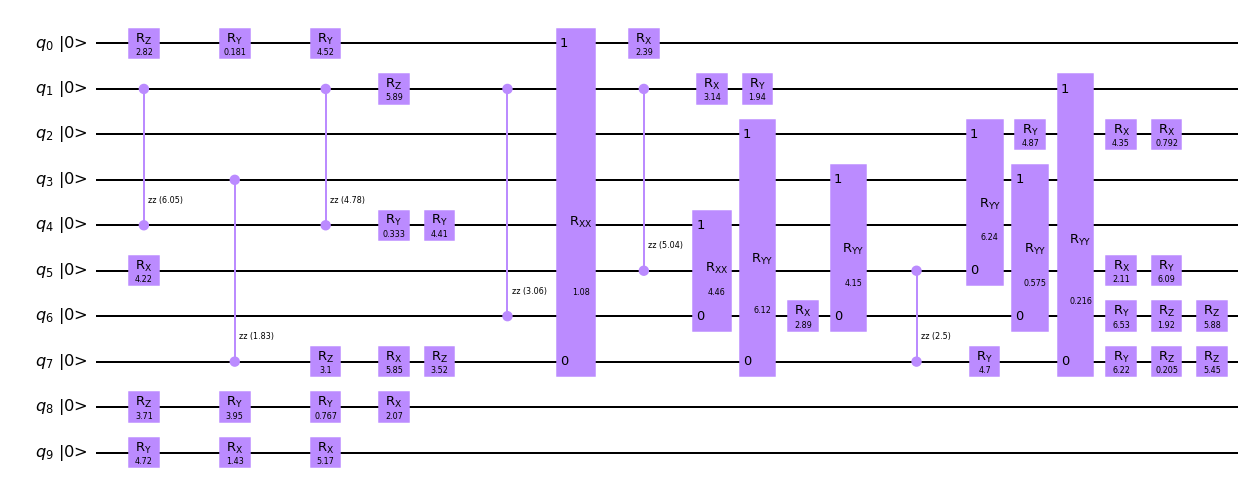

In [16]:
final_circuit.draw(initial_state=True, output="mpl")

However, the final circuit is quite complicated (too many gates) to simulate a super easy Hamiltonian. So, these evolutionary algorithms are probably good only when we have no prior idea of how the final circuit should be, because they span the set of all possible circuits.

In [29]:
values1=[]
for i in func_val:
    values1.append(i[0].real)

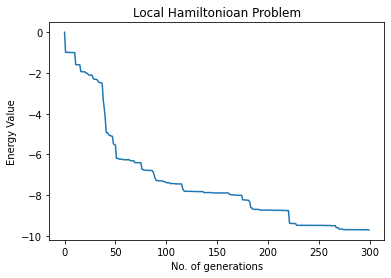

In [30]:
plt.plot(values1)
plt.xlabel('No. of generations')
plt.ylabel('Energy Value')
plt.title('Local Hamiltonioan Problem')
plt.show()

### 2) Transverse Field Ising Model 

We next considered performance for the 1d spin-chain with
correlation in the z-component and a transverse magnetic field with x-axis orientation . <br> Hence
we get the Hamiltonian :


![](images/2.PNG)

We only consider the ordered phase and get (anti-) ferromagnetic behavior for (J > 0) J < 0. <br>
For our purposes, we chose J; h = 1, i.e. opting for the anti-ferromagnetic behavior. <br>



The TFI is well-known to exhibit local minima, causing
purely gradient based methods to fail. <br>
Our algorithms capability to navigate such landscapes
is intuitively dependent on the distance traversed by each generation in Hilbert space. <br> For our
settings of hyperparameters, the vanishing of the energy landscape slope should not prohibit global
optimization.


In [31]:
H=[[0 for i in range(1024)] for j in range(1024) ] #gives us Hamiltonian for Transverse Field Ising Model


for i in range(10):
    q=QuantumRegister(10,'q')
    circuit = QuantumCircuit(q)
    circuit.z(i)
    if i<9:
        circuit.z(i+1)
    else:
        circuit.z(0)
        #pass
    op = qi.Operator(circuit)
    array=op.data
    H-=array



for i in range(10):
    q=QuantumRegister(10,'q')
    circuit = QuantumCircuit(q)
    circuit.x(i)
    op = qi.Operator(circuit)
    array=op.data
    H-=array

In [32]:
results = la.eig(H) #Expected minimum energy
print(min(results[0]))

(-12.784906442999398+1.498675384850868e-30j)


In [33]:
func_val=get_min_circuit(H) #gives the value of optimization function at each generation

In [34]:
func_val[-1][0] #gives the value of target function on last generation

array([-11.63157105-8.8817842e-16j])

We are getting minimum energy as -11.6, pretty close to the actual minimum of -12.7

In [35]:
final_circuit=get_circuit(func_val[-1][1])

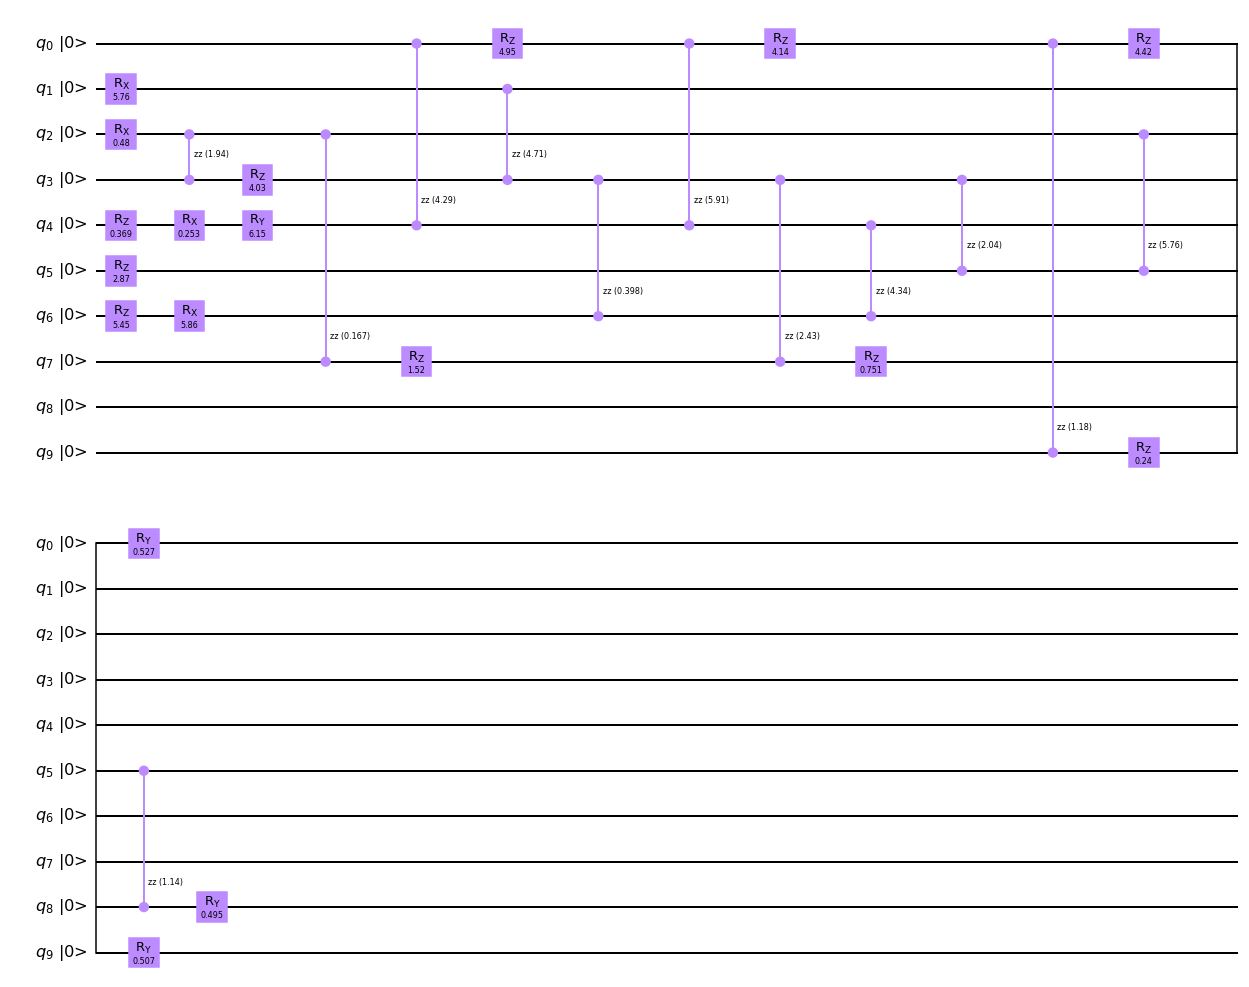

In [36]:
final_circuit.draw(initial_state=True, output="mpl")

In [37]:
values2=[]
for i in func_val:
    values2.append(i[0].real)

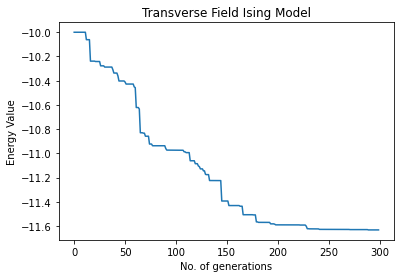

In [39]:
plt.plot(values2)
plt.xlabel('No. of generations')
plt.ylabel('Energy Value')
plt.title('Transverse Field Ising Model')
plt.show()

### 3) Sherrington-Kirkpatrick Model 

The SK model simulates the behaviour of a frustrated spin
glass and was previously used as a benchmark model in quantum computing experiments. <br>
<br> The model is given by the Hamiltonian :


![](images/3.PNG)

where \\( J_{ij} \\) are randomly assigned couplings with \\( J_{ij} \: \epsilon \: \{-1,1 \} \\)

For every run we constructed a
randomly sampled instance of the SK model. However, the ground state energy of spin glass model
instances is subject to concentration, hence properties such as optimization difficulty and ground
state entanglement can be expected to behave consistently. Note that such a Hamiltonian
consists exclusively of correlation terms, which is why we expect this optimization problem to
constitute a considerably harder problem than the previous experiments.


In [3]:
H=[[0 for i in range(1024)] for j in range(1024) ] #gives us Hamiltonian of Sherrington-Kirkpatrick Model


for i in range(10):
    for j in range(i+1,10):
        q=QuantumRegister(10,'q')
        circuit = QuantumCircuit(q)
        circuit.z(i)
        circuit.z(j)
        op = qi.Operator(circuit)
        array=op.data
        types=[1,-1]
        factor=random.choice(types) 
        if factor==1:
            H+=array
        else:
            H-=array

In [4]:
results = la.eig(H) #Expected minimum energy
print(min(results[0]))

(-17+0j)


In [5]:
func_val=get_min_circuit(H) #gives the value of optimization function at each generation

In [6]:
func_val[-1][0] #gives the value of target function on last generation

array([-16.99801203+1.11022302e-16j])

We are getting minimum energy as -16.9, pretty close to the actual minimum of -17

In [7]:
final_circuit=get_circuit(func_val[-1][1])

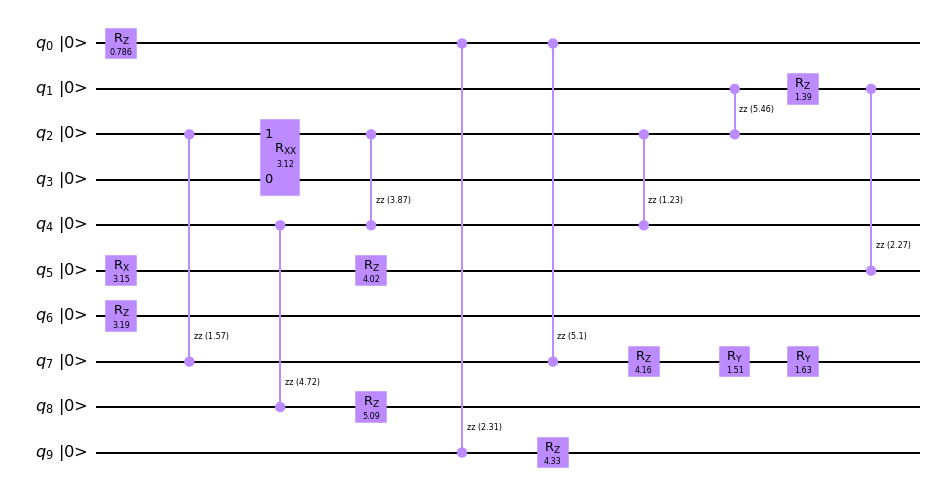

In [8]:
final_circuit.draw(initial_state=True, output="mpl")

In [9]:
values3=[]
for i in func_val:
    values3.append(i[0].real)

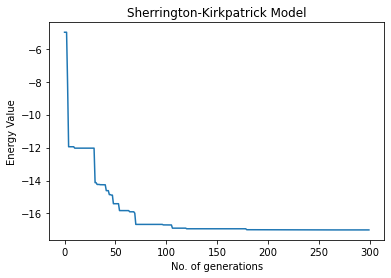

In [10]:
plt.plot(values3)
plt.xlabel('No. of generations')
plt.ylabel('Energy Value')
plt.title('Sherrington-Kirkpatrick Model')
plt.show()

### 4) Sachdev-Ye-Kitaev (SYK) Model

The SYK model is built out of 2n Majorana
fermions in 1d, i.e. the operators 
\\(  \gamma _i \\) , with i = 1, ..., 2n,
satisfying the following anti-commutation relations

![](images/10.PNG)

where \\(  \delta _{ij} \\) denotes the Kronecker delta. The SYK Hamiltonian is an all-to-all Hamiltonian, which couples all the
Majorana fermions together in a fully non-local fashion,
consisting of the following q-body interaction terms with
q \\(  \geq \\) 2 being an even integer:

![](images/11.PNG)

where the coupling constants \\(  J _{i_1...i_q} \\) are randomly sampled from the Gaussian distribution of mean 0 and variance:



![](images/12.PNG)

where \\(  J ^2 \\) is a constant which we set to be equal to one.

In [ ]:
H=Hamiltonian_for_SYK()

In [3]:
results = la.eig(H) #Expected minimum energy
print(min(results[0]))

(-63.40199159898315-1.4915382644808436e-15j)


In [4]:
func_val=get_min_circuit(H) #gives the value of optimization function at each generation

In [5]:
func_val[-1][0] #gives the value of target function on last generation

array([-19.14262385-1.66533454e-15j])

As can be seen, our model doesn't perform well here. That's because the SYK model is too complicated (i.e. strongly interacting and involves randomness of the couplings) for such basic algorithm of evolution.

In [6]:
final_circuit=get_circuit(func_val[-1][1])

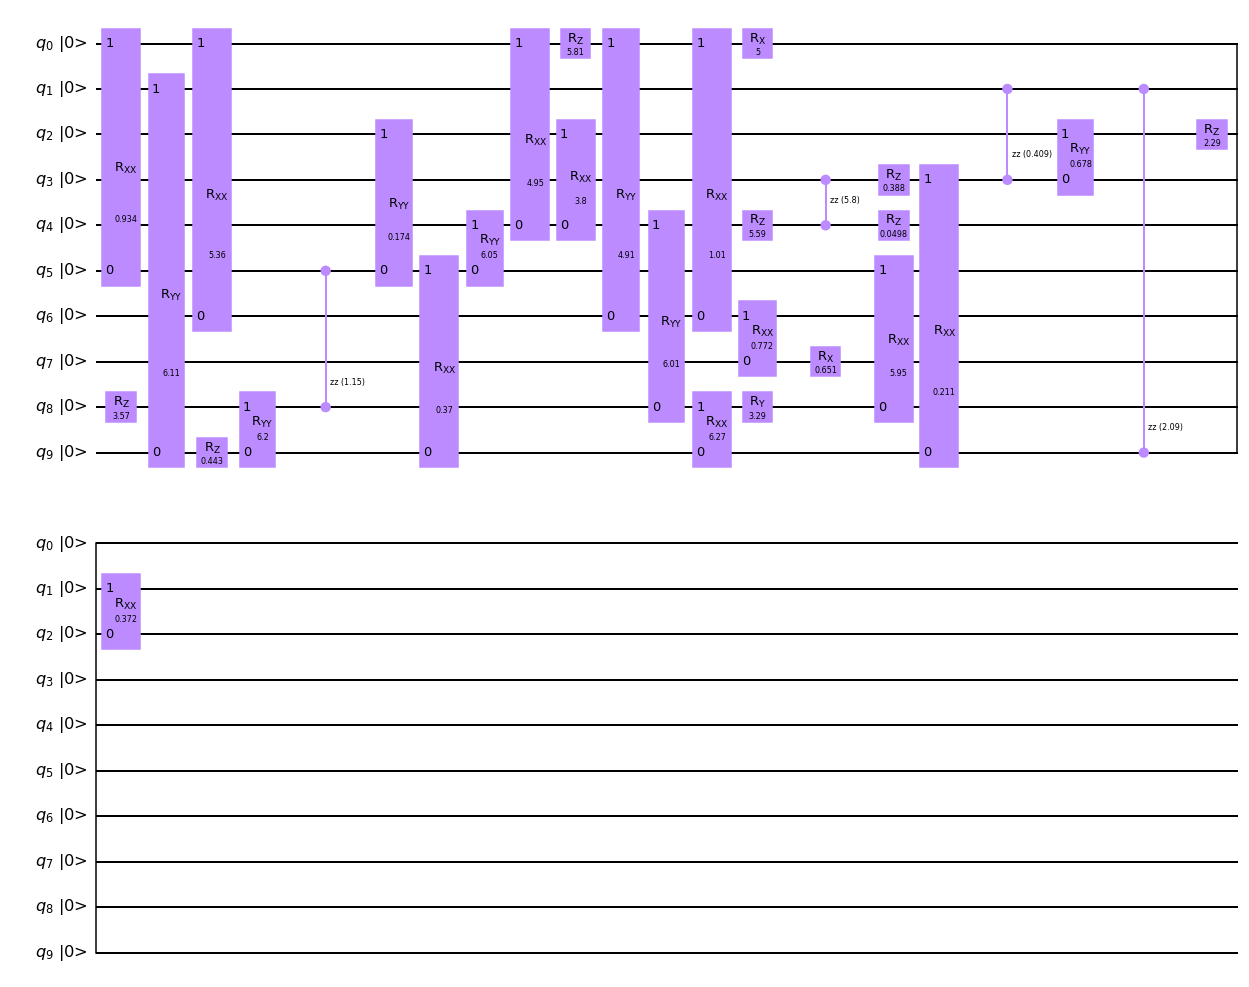

In [7]:
final_circuit.draw(initial_state=True, output="mpl")

In [8]:
values4=[]
for i in func_val:
    values4.append(i[0].real)

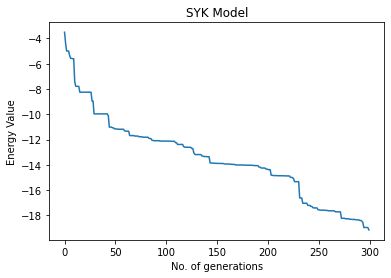

In [9]:
plt.plot(values4)
plt.xlabel('No. of generations')
plt.ylabel('Energy Value')
plt.title('SYK Model')
plt.show()

## Results

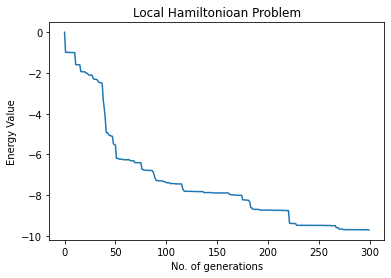

In [50]:
plt.plot(values1)
plt.xlabel('No. of generations')
plt.ylabel('Energy Value')
plt.title('Local Hamiltonioan Problem')
plt.show()

The results for the local problem are depicted in the above graph. <br>
In this experiment we optimize
a trivial sum of local \\( \sigma _x \\) Paulis over the full set of qubits. <br>
Since the problem lacks a correlation requirement between the qubits we expect fast
convergence  and observe so in the above graph with all runs rapidly
converging to the global minimum.


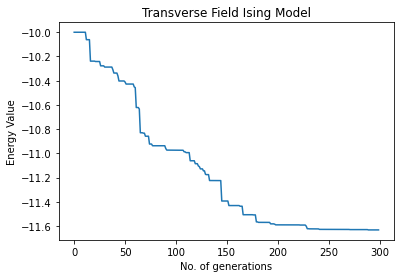

In [51]:
plt.plot(values2)
plt.xlabel('No. of generations')
plt.ylabel('Energy Value')
plt.title('Transverse Field Ising Model')
plt.show()

We next considered performance for the transverse-field Ising model (above graph). <br>
The simulated runs show reliable convergence.


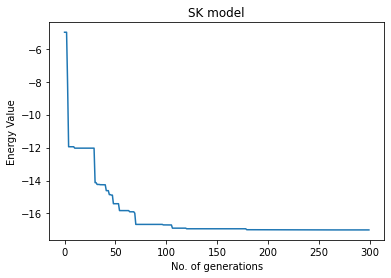

In [11]:
plt.plot(values3)
plt.xlabel('No. of generations')
plt.ylabel('Energy Value')
plt.title('SK model')
plt.show()

Finally, the results of optimization of the SK model are shown in the above graph. <br>
In all cases the early
generations exhibit reliable optimization and show strong capability to navigate entangled Hilbert
space. <br> However, the model’s particular proneness to local minima is exhibit by longer optimization
stretches without progress.


## References

1) Franken, L., et al. “Gradient-Free Quantum Optimization on NISQ Devices.” ArXiv:2012.13453 [Quant-Ph, Stat], Mar. 2021. arXiv.org, http://arxiv.org/abs/2012.13453
<br><br>
2) Joonho Kim, Jaedeok Kim, Dario Rosa.  “Universal Effectiveness of High-Depth Circuits in Variational Eigenproblems.” ArXiv:2010.00157 [Cond-Mat, Physics:Hep-Th, Physics:Quant-Ph], Mar. 2021. arXiv.org, http://arxiv.org/abs/2010.00157
<br><br>
3) Chien, Riley W., and James D. Whitfield. “Custom Fermionic Codes for Quantum Simulation.” ArXiv:2009.11860 [Quant-Ph], Sept. 2020. arXiv.org, http://arxiv.org/abs/2009.11860

Work done by Saksham Sarwari (ssarwari@ph.iitr.ac.in)